# Chapter 2

## 2.1 A $k$-armed Bandit Problem

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import typing
%matplotlib inline

- Expected reward a.k.a. *value* of the action $a$, $q_*(a)$
- Time step $t$
- Action $A_t$
- Reward $R_t$
- Estimated value $Q_t(a)$

$$
\DeclareMathOperator*{\argmax}{arg\,max}
q_*(a) = \mathbb{E}[R_t|A_t=a]
$$

## 2.2 Action-value Methods

$$
Q_t(a) = \frac{\textrm{sum of rewards when $a$ taken prior to $t$}}{\textrm{number of times $a$ taken prior to $t$}}
=
\frac{\sum_{i=1}^{t-1}R_i \cdot \mathbb{I}_{A_i = a}}{\sum_{i=1}^{t-1}\mathbb{I}_{A_i = a}}
$$

Due to the law of large numbers, $Q_t(a) \to q_*(a) \; (t \to \infty)$.

In [25]:
def estimate_q(a: int, rewards: typing.Sequence[float], actions: typing.Sequence[int]):
    """Computes Q_t(A) using sample-average method.
    
    NOTE:
        t == len(rewards)
        t == len(actions)
    """
    assert len(rewards) == len(actions)
    q = 0
    n = 0
    for t in range(len(actions)):
        if a == actions[t]:
            q += rewards[t]
            n += 1
    if n == 0:
        return 0
    else:
        return q / n

$$
A_t = \argmax_a Q_t(a)
$$

In [26]:
def greedy_action_selection(
        available_actions: typing.Sequence[int],
        rewards: typing.Sequence[float],
        actions: typing.Sequence[int]):
    """Greedy action selection (equation (2.2))
    """
    assert len(rewards) == len(actions)
    estimates = [estimate_q(a, rewards, actions) for a in available_actions]
    estimates = np.asarray(estimates)
    return np.argmax(estimates)

$\varepsilon$-greedy method

$$
\begin{align}
\varepsilon &\sim U(0,1)\\
A_t &= \left\{\begin{aligned}
\argmax_a Q_t(a) \qquad &\textrm{if} \; \varepsilon > 0.5 \\
(\textrm{random action}) \qquad &\textrm{overwise}
\end{aligned}\right.
\end{align}
$$

In [30]:
def e_greedy_action_selection(
        available_actions: typing.Sequence[int],
        rewards: typing.Sequence[float],
        actions: typing.Sequence[int],
        threshold: float):
    """e-Greedy action selection (equation (2.2))
    """
    assert len(rewards) == len(actions)
    e = np.random.uniform()
    if e > threshold:
        estimates = [estimate_q(a, rewards, actions) for a in available_actions]
        estimates = np.asarray(estimates)
        return np.argmax(estimates)
    else:
        index = np.random.randint(0, len(available_actions))
        return available_actions[index]

## 2.3 The 10-armed Testbed

In [31]:
class Testbed:
    
    def __init__(self, k=10):
        self.k = k
        self.q_ast = [np.random.uniform(0, 1) for _ in range(k)]
        
    def get_reward(self, a):
        return self.q_ast[a] + np.random.uniform(0, 1)
    
    def run(self, num_steps=1000, num_runs=2000, threshold=0.1):
        avg_actions = [0 for _ in range(num_steps)]  # avg through runs
        avg_rewards = [0 for _ in range(num_steps)]  # avg through runs
        for _ in range(num_runs):
            actions = []
            rewards = []
            q_est = [0 for _ in range(self.k)]
            for i in range(num_steps):
                a = e_greedy_action_selection(list(range(self.k)), rewards, actions, threshold)
                r = self.get_reward(a)
                actions.append(a)
                rewards.append(r)
                avg_actions[i] += a / num_runs
                avg_rewards[i] += r / num_runs
        return avg_actions, avg_rewards

In [32]:
testbed = Testbed()
avg_actions1, avg_rewards1 = testbed.run(threshold=0.1)
avg_actions2, avg_rewards2 = testbed.run(threshold=0.01)
avg_actions3, avg_rewards3 = testbed.run(threshold=0)

KeyboardInterrupt: 

In [ ]:
x = list(range(1000))
plt.plot(x, avg_actions1)
plt.plot(x, avg_actions2)
plt.plot(x, avg_actions3)
plt.show()

In [3]:
def update_estimate_average(action, actions, rewards):
    assert len(actions) == len(rewards)
    q = 0
    counts = 0
    for i in range(len(actions)):
        if action == actions[i]:
            q += rewards[i]
            counts += 1
    return q / counts

In [4]:
def update_estimate_incremental(q, r, step_size):
    return q + step_size * (r - q)

In [35]:
def run_average(k, q, num_runs, num_steps, threshold):
    avg_actions = np.zeros(num_steps)
    avg_rewards = np.zeros(num_steps)
    avg_estimates = np.zeros(k)
    for _ in range(num_runs):
        actions = [-1 for _ in range(num_steps)]
        rewards = [-1 for _ in range(num_steps)]
        estimates = np.zeros(k)
        for i in range(num_steps):
            e = np.random.uniform()
            q = [qi + np.random.normal(0, 0.01) for qi in q]
            action = np.argmax(estimates) if e > threshold else int(np.random.uniform(0, k))
            reward = q[action]
            actions[i] = action
            rewards[i] = reward
            estimates[action] = update_estimate_average(action, actions, rewards)
            avg_actions[i] += action / num_runs
            avg_rewards[i] += reward / num_runs
        avg_estimates += estimates / num_runs
    return avg_actions, avg_rewards, avg_estimates

In [25]:
def run_incremental(k, q, num_runs, num_steps, threshold, step_size=lambda i: (1/(1+i))):
    avg_actions = np.zeros(num_steps)
    avg_rewards = np.zeros(num_steps)
    avg_estimates = np.zeros(k)
    for _ in range(num_runs):
        estimates = np.zeros(k)
        for i in range(num_steps):
            e = np.random.uniform()
            q = [qi + np.random.normal(0, 0.01) for qi in q]
            action = np.argmax(estimates) if e > threshold else int(np.random.uniform(0, k))
            reward = q[action]
            alpha = step_size(i)
            estimates[action] = update_estimate_incremental(estimates[action], reward, alpha)
            avg_actions[i] += action / num_runs
            avg_rewards[i] += reward / num_runs
        avg_estimates += estimates / num_runs
    return avg_actions, avg_rewards, avg_estimates

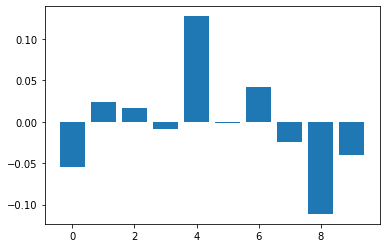

In [36]:
num_steps = 10000
num_runs = 20
k = 10
q = [0 + np.random.normal(0, 0.1) for _ in range(k)]

x = list(range(len(q)))
y = q
plt.bar(x, y)
plt.show()

In [37]:
avg_actions, avg_rewards, estimates = run_average(k, q, num_runs, num_steps, threshold=0.1)

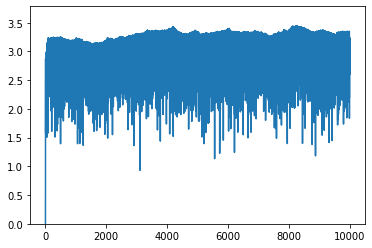

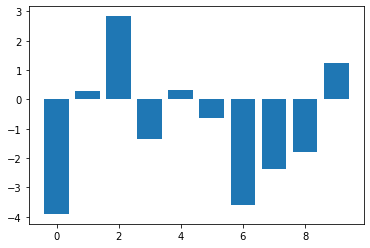

In [38]:
x = list(range(len(avg_rewards)))
y = avg_rewards
plt.plot(x, y)
plt.ylim(bottom=0)
plt.show()

x = list(range(len(estimates)))
y = estimates
plt.bar(x, y)
plt.show()

In [39]:
avg_actions, avg_rewards, estimates = run_incremental(k, q, num_runs, num_steps, threshold=0.1)

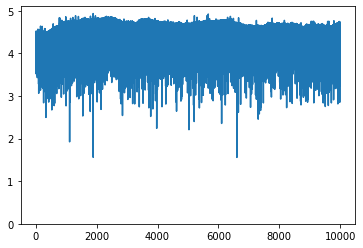

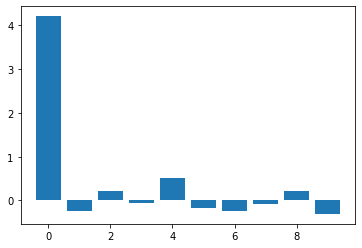

In [40]:
x = list(range(len(avg_rewards)))
y = avg_rewards
plt.plot(x, y)
plt.ylim(bottom=0)
plt.show()

x = list(range(len(estimates)))
y = estimates
plt.bar(x, y)
plt.show()

In [41]:
avg_actions, avg_rewards, estimates = run_incremental(k, q, num_runs, num_steps, threshold=0.1, step_size=lambda i: 0.1)

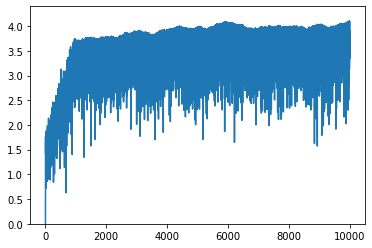

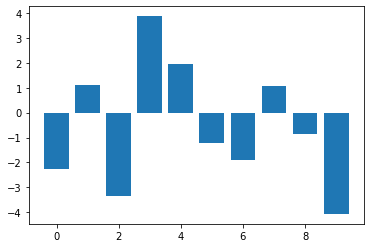

In [42]:
x = list(range(len(avg_rewards)))
y = avg_rewards
plt.plot(x, y)
plt.ylim(bottom=0)
plt.show()

x = list(range(len(estimates)))
y = estimates
plt.bar(x, y)
plt.show()